Mirella Glowinska
C0027574
Dataset source: https://www.kaggle.com/datasets/rakannimer/air-passengers
Tutorial: https://www.datacamp.com/tutorial/lstm-python-stock-market

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

df = pd.read_csv("../datasets/AirPassengers.csv", parse_dates=['Month'], index_col='Month')

print(f"Total records: {len(df)}")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Passenger stats:\n{df['#Passengers'].describe()}")

passengers = df['#Passengers'].values.astype(float)

Total records: 144
Date range: 1949-01-01 to 1960-12-01
Missing values: 0
Passenger stats:
count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: #Passengers, dtype: float64


In [ ]:
def prepare_data(data, look_back=12, test_size=0.2):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(scaled_data)-look_back):
        # x - 18 previous months
        X.append(scaled_data[i:i+look_back, 0])
        # y - next month’s value
        y.append(scaled_data[i+look_back, 0])
    
    split = int(len(X)*(1-test_size))
    X_train, X_test = np.array(X[:split]), np.array(X[split:])
    y_train, y_test = np.array(y[:split]), np.array(y[split:])
    
    X_train = X_train.reshape(*X_train.shape, 1)
    X_test = X_test.reshape(*X_test.shape, 1)
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler = prepare_data(passengers, look_back=18)


def build_model(look_back):
    model = Sequential([
        Bidirectional(LSTM(100, return_sequences=True, 
        #(18, 1) - 1 steps for each input
        input_shape=(look_back, 1))),
        Dropout(0.4),
        LSTM(50, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, 
                loss='mse', 
                metrics=['mae'])
    return model

model = build_model(look_back=18)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

def inverse_scale(scaler, data):
    return scaler.inverse_transform(data.reshape(-1, 1)).flatten()

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = inverse_scale(scaler, train_pred)
test_pred = inverse_scale(scaler, test_pred)
y_train = inverse_scale(scaler, y_train)
y_test = inverse_scale(scaler, y_test)

def print_metrics(y_true, y_pred, label):
    print(f"\n{label} Metrics:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    
print_metrics(y_train, train_pred, "Training")
print_metrics(y_test, test_pred, "Test")

Epoch 1/500


C:\Users\Mirella\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0998 - mae: 0.2669

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 0.0971 - mae: 0.2620 - val_loss: 0.0374 - val_mae: 0.1457
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0126 - mae: 0.0883

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0130 - mae: 0.0897 - val_loss: 0.0234 - val_mae: 0.1171
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0127 - mae: 0.0847 - val_loss: 0.0454 - val_mae: 0.1648
Epoch 4/500
4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0087 - mae: 0.0718

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0093 - mae: 0.0735 - val_loss: 0.0213 - val_mae: 0.1198
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0126 - mae: 0.0830 - val_loss: 0.0267 - val_mae: 0.1208
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0116 - mae: 0.0704 - val_loss: 0.0336 - val_mae: 0.1356
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0109 - mae: 0.0801 - val_loss: 0.0215 - val_mae: 0.1211
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0082 - mae: 0.0711 - val_loss: 0.0218 - val_mae: 0.1181
Epoch 9/500
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0099 - mae: 0.0723

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0095 - mae: 0.0716 - val_loss: 0.0213 - val_mae: 0.1199
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0092 - mae: 0.0709 - val_loss: 0.0224 - val_mae: 0.1181
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0115 - mae: 0.0767 - val_loss: 0.0230 - val_mae: 0.1264
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0078 - mae: 0.0655 - val_loss: 0.0222 - val_mae: 0.1237
Epoch 13/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0098 - mae: 0.0741 - val_loss: 0.0229 - val_mae: 0.1265
Epoch 14/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0084 - mae: 0.0676 - val_loss: 0.0214 - val_mae: 0.1176
Epoch 15/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0125 - mae: 0.0841 - val_loss: 0.0215 - val_mae: 0.1170
Epoch 16/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0101 - mae: 0.0745 - val_loss: 0.0345 - val_mae: 0.1389
Epoch 17/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0109 - mae: 0.07

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0080 - mae: 0.0649 - val_loss: 0.0208 - val_mae: 0.1189
Epoch 21/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0078 - mae: 0.0672 - val_loss: 0.0208 - val_mae: 0.1158
Epoch 22/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0157 - mae: 0.0932 - val_loss: 0.0215 - val_mae: 0.1154
Epoch 23/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0098 - mae: 0.0727

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0096 - mae: 0.0720 - val_loss: 0.0203 - val_mae: 0.1152
Epoch 24/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0076 - mae: 0.0685 - val_loss: 0.0233 - val_mae: 0.1306
Epoch 25/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0099 - mae: 0.0709 - val_loss: 0.0217 - val_mae: 0.1144
Epoch 26/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0084 - mae: 0.0682 - val_loss: 0.0225 - val_mae: 0.1147
Epoch 27/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0082 - mae: 0.0661

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0082 - mae: 0.0664 - val_loss: 0.0199 - val_mae: 0.1153
Epoch 28/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0097 - mae: 0.0751 - val_loss: 0.0255 - val_mae: 0.1176
Epoch 29/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0085 - mae: 0.0721

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0085 - mae: 0.0717 - val_loss: 0.0197 - val_mae: 0.1128
Epoch 30/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0093 - mae: 0.0724 - val_loss: 0.0197 - val_mae: 0.1153
Epoch 31/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0088 - mae: 0.0671 - val_loss: 0.0212 - val_mae: 0.1126
Epoch 32/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0087 - mae: 0.0701 - val_loss: 0.0200 - val_mae: 0.1170
Epoch 33/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0092 - mae: 0.0741

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0094 - mae: 0.0743 - val_loss: 0.0193 - val_mae: 0.1120
Epoch 34/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0073 - mae: 0.0688

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0075 - mae: 0.0691 - val_loss: 0.0192 - val_mae: 0.1115
Epoch 35/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061 - mae: 0.0574

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0063 - mae: 0.0579 - val_loss: 0.0191 - val_mae: 0.1115
Epoch 36/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0083 - mae: 0.0665 - val_loss: 0.0192 - val_mae: 0.1108
Epoch 37/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0105 - mae: 0.0774

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0104 - mae: 0.0772 - val_loss: 0.0190 - val_mae: 0.1123
Epoch 38/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066 - mae: 0.0627

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0069 - mae: 0.0637 - val_loss: 0.0189 - val_mae: 0.1101
Epoch 39/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - mae: 0.0712

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0108 - mae: 0.0713 - val_loss: 0.0187 - val_mae: 0.1112
Epoch 40/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0070 - mae: 0.0641

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0070 - mae: 0.0641 - val_loss: 0.0186 - val_mae: 0.1092
Epoch 41/500
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0062 - mae: 0.0625

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0063 - mae: 0.0628 - val_loss: 0.0185 - val_mae: 0.1087
Epoch 42/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0093 - mae: 0.0721 - val_loss: 0.0198 - val_mae: 0.1080
Epoch 43/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0084 - mae: 0.0716 - val_loss: 0.0186 - val_mae: 0.1071
Epoch 44/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0091 - mae: 0.0682 - val_loss: 0.0220 - val_mae: 0.1100
Epoch 45/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0067 - mae: 0.0613

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0068 - mae: 0.0614 - val_loss: 0.0181 - val_mae: 0.1102
Epoch 46/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0086 - mae: 0.0711 - val_loss: 0.0186 - val_mae: 0.1044
Epoch 47/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0052 - mae: 0.0570

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0053 - mae: 0.0574 - val_loss: 0.0173 - val_mae: 0.1062
Epoch 48/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0077 - mae: 0.0654 - val_loss: 0.0190 - val_mae: 0.1039
Epoch 49/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0063 - mae: 0.0592 - val_loss: 0.0182 - val_mae: 0.1018
Epoch 50/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0077 - mae: 0.0695

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0077 - mae: 0.0696 - val_loss: 0.0166 - val_mae: 0.1019
Epoch 51/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0089 - mae: 0.0654 - val_loss: 0.0308 - val_mae: 0.1338
Epoch 52/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0063 - mae: 0.0573

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0064 - mae: 0.0580 - val_loss: 0.0164 - val_mae: 0.0996
Epoch 53/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0077 - mae: 0.0663 - val_loss: 0.0195 - val_mae: 0.1022
Epoch 54/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061 - mae: 0.0605

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0063 - mae: 0.0610 - val_loss: 0.0161 - val_mae: 0.0934
Epoch 55/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0102 - mae: 0.0736

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0100 - mae: 0.0729 - val_loss: 0.0134 - val_mae: 0.0874
Epoch 56/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0059 - mae: 0.0562 - val_loss: 0.0137 - val_mae: 0.0831
Epoch 57/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0084 - mae: 0.0636

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0083 - mae: 0.0632 - val_loss: 0.0100 - val_mae: 0.0721
Epoch 58/500
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0059 - mae: 0.0563

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0061 - mae: 0.0570 - val_loss: 0.0092 - val_mae: 0.0684
Epoch 59/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0068 - mae: 0.0576 - val_loss: 0.0104 - val_mae: 0.0714
Epoch 60/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0051 - mae: 0.0569

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0051 - mae: 0.0566 - val_loss: 0.0066 - val_mae: 0.0664
Epoch 61/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0037 - mae: 0.0464 - val_loss: 0.0104 - val_mae: 0.0847
Epoch 62/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0049 - mae: 0.0509 - val_loss: 0.0229 - val_mae: 0.1266
Epoch 63/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0052 - mae: 0.0545 - val_loss: 0.0085 - val_mae: 0.0763
Epoch 64/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0062 - mae: 0.0594 - val_loss: 0.0205 - val_mae: 0.1120
Epoch 65/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0054 - mae: 0.0531 - val_loss: 0.0109 - val_mae: 0.0759
Epoch 66/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0061 - mae: 0.0585 - val_loss: 0.0092 - val_mae: 0.0697
Epoch 67/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0050 - mae: 0.0503 - val_loss: 0.0070 - val_mae: 0.0641
Epoch 68/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0051 - mae: 0.05

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0032 - mae: 0.0463 - val_loss: 0.0059 - val_mae: 0.0605
Epoch 75/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0047 - mae: 0.0518 - val_loss: 0.0184 - val_mae: 0.1127
Epoch 76/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0038 - mae: 0.0475

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0038 - mae: 0.0476 - val_loss: 0.0059 - val_mae: 0.0623
Epoch 77/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0040 - mae: 0.0478 - val_loss: 0.0102 - val_mae: 0.0771
Epoch 78/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0042 - mae: 0.0490 - val_loss: 0.0066 - val_mae: 0.0623
Epoch 79/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0040 - mae: 0.0464 - val_loss: 0.0078 - val_mae: 0.0679
Epoch 80/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0057 - mae: 0.0534 - val_loss: 0.0128 - val_mae: 0.0877
Epoch 81/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0033 - mae: 0.0424 - val_loss: 0.0088 - val_mae: 0.0726
Epoch 82/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0060 - mae: 0.0524 - val_loss: 0.0071 - val_mae: 0.0659
Epoch 83/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0043 - mae: 0.0485 - val_loss: 0.0155 - val_mae: 0.1032
Epoch 84/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0053 - mae: 0.05

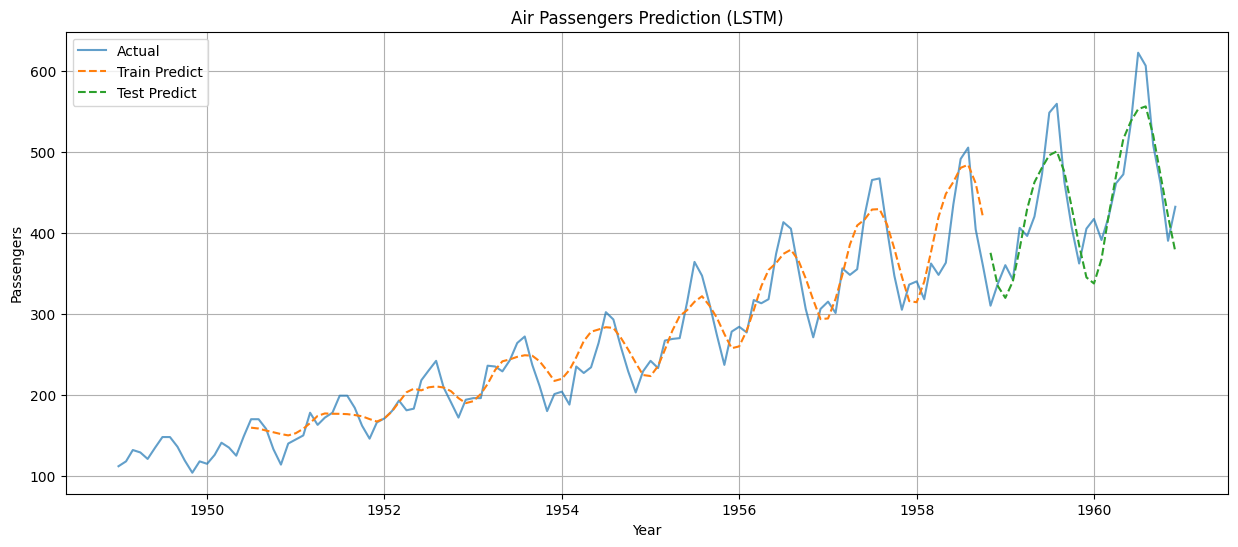

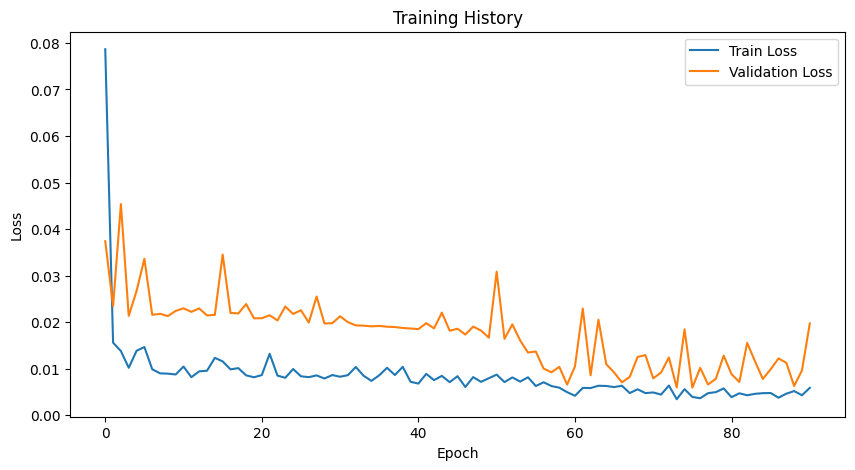

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


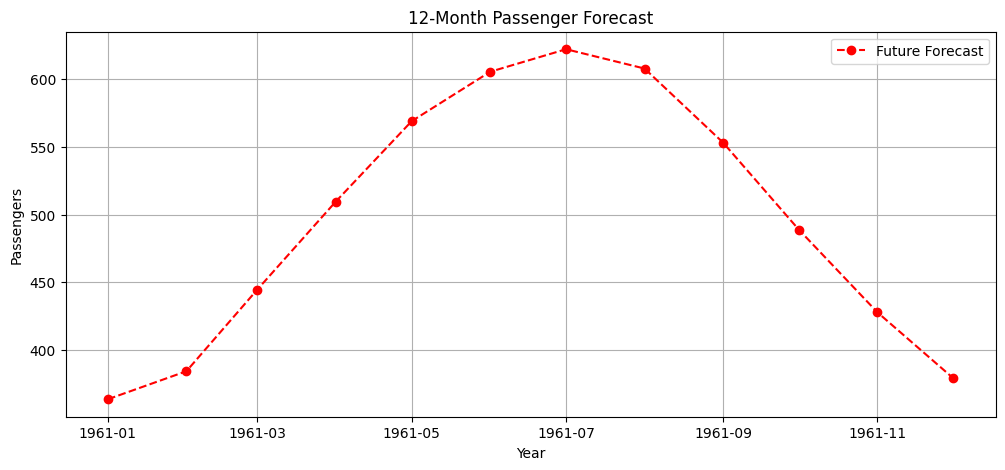

In [4]:

import joblib

plt.figure(figsize=(15, 6))

plt.plot(df.index, passengers, label='Actual', alpha=0.7)

train_dates = df.index[18:18+len(train_pred)]
plt.plot(train_dates, train_pred, label='Train Predict', linestyle='--')

test_dates = df.index[18+len(train_pred):18+len(train_pred)+len(test_pred)]
plt.plot(test_dates, test_pred, label='Test Predict', linestyle='--')

plt.title('Air Passengers Prediction (LSTM)')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

def forecast_future(model, last_sequence, steps=12):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(steps):
        pred = model.predict(current_sequence.reshape(1, len(current_sequence), 1))
        predictions.append(pred[0,0])
        current_sequence = np.append(current_sequence[1:], pred)
    
    return inverse_scale(scaler, np.array(predictions))

last_seq = scaler.transform(passengers[-18:].reshape(-1, 1)).flatten()
future_pred = forecast_future(model, last_seq, steps=12)

future_dates = pd.date_range(
    start=df.index[-1] + pd.DateOffset(months=1),
    periods=12,
    freq='MS'
)

plt.figure(figsize=(12, 5))
plt.plot(future_dates, future_pred, 'r--o', label='Future Forecast')
plt.title('12-Month Passenger Forecast')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

joblib.dump(scaler, '../Deployment/air_passenger_scaler.pkl')
model.save('../Deployment/air_passenger_lstm.h5')

